#### Organizing all the imports

In [1]:
import csv
import pandas as pd
import matplotlib
% matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools import add_constant
from sklearn.linear_model import LogisticRegression
import numpy as np
from pandas.tools.plotting import scatter_matrix
import sklearn.metrics as skm
from sklearn.preprocessing import scale
from pandasql import sqldf
from scipy.stats import skew
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn import preprocessing
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_curve, precision_score, recall_score, f1_score, auc, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

#### Loading the data 

In [3]:
def load_datasets():
    '''
    Load csv's into dataframes
    '''
    fraud_data = pd.read_csv('./Fraud_Data.csv')
    ip_data = pd.read_csv('./IpAddress_to_Country.csv')
    return fraud_data, ip_data

def match_country_to_ip(ip=None):
    '''
    Match an IP address with country name
    IP:
        ip - ip address, float
    '''
    match = (ip <= ip_data['upper_bound_ip_address']) & ( ip >= ip_data['lower_bound_ip_address'])
    if match.any():
        return ip_data['country'][match].to_string(index=False)
    else:
        return 'unknown'


def add_countries():
    '''
    Add countries to fraud dataframe
    '''
    fraud_data['country'] = fraud_data['ip_address'].apply(lambda x: match_country_to_ip(x))


if __name__ == '__main__':

    fraud_data, ip_data = load_datasets()
    add_countries()
    fraud_data.to_csv('fraud_data_with_country.csv')

In [38]:
data = fraud_data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 17 columns):
user_id                       151112 non-null int64
signup_time                   151112 non-null datetime64[ns]
purchase_time                 151112 non-null datetime64[ns]
purchase_value                151112 non-null int64
device_id                     151112 non-null object
source                        151112 non-null object
browser                       151112 non-null object
sex                           151112 non-null int64
age                           151112 non-null int64
ip_address                    151112 non-null float64
class                         151112 non-null int64
country                       151112 non-null object
userids_per_deviceid          151112 non-null int64
userids_per_ipaddress         151112 non-null int64
mean_number_of_userids        151112 non-null float64
signup_to_purchase_seconds    151112 non-null int64
conversion_time               1

### 1) Determining the country of each IP, column country is added to the fraud_data frame 

In [39]:
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,userids_per_deviceid,userids_per_ipaddress,mean_number_of_userids,signup_to_purchase_seconds,conversion_time
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,0,39,7.327584e+08,0,Japan,1,1,1.0,13882,52 days 03:51:22
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,1,53,3.503114e+08,0,United States,1,1,1.0,17944,0 days 04:59:04
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,0,53,2.621474e+09,1,United States,12,12,12.0,1,0 days 00:00:01
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,0,41,3.840542e+09,0,unknown,1,1,1.0,60085,5 days 16:41:25
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,0,45,4.155831e+08,0,United States,1,1,1.0,41461,50 days 11:31:01


### First, exploring the correlation between sex and class. Males make up more of the customer base of the company and thus are also involved in more of the fraud cases. It doesn't look like one gender is more likely to participate in fraud though, just that one gender tends to use the site more in general.

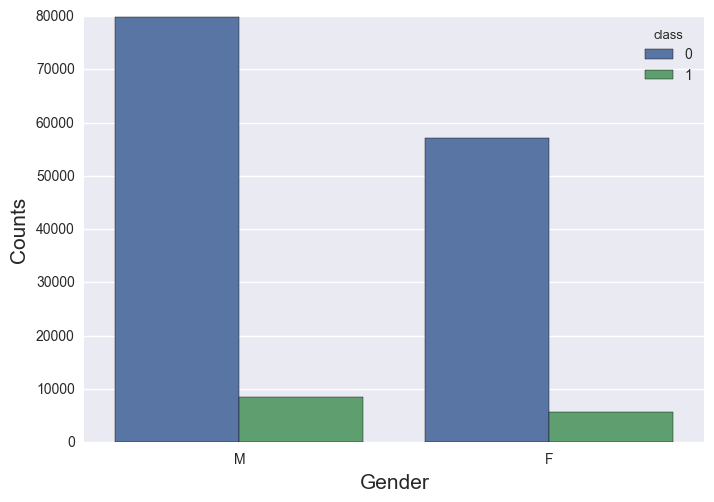

In [18]:
sns.countplot(x='sex', hue='class', data=data)
plt.xlabel("Gender", fontsize=15)
plt.ylabel("Counts", fontsize=15)

### Relation between purchase and fraud, Although there is a slight increase in the average purchase value associated with fraudulent activity, the errors bars are far too high to spot a real trend.

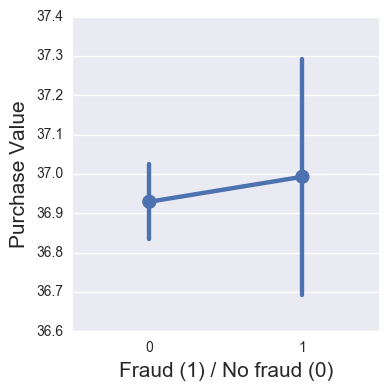

In [19]:
sns.factorplot(x="class", y="purchase_value", data=data)
plt.xlabel("Fraud (1) / No fraud (0)", fontsize=15)
plt.ylabel("Purchase Value", fontsize=15)

### Ordering countries where most amount of fraud originates

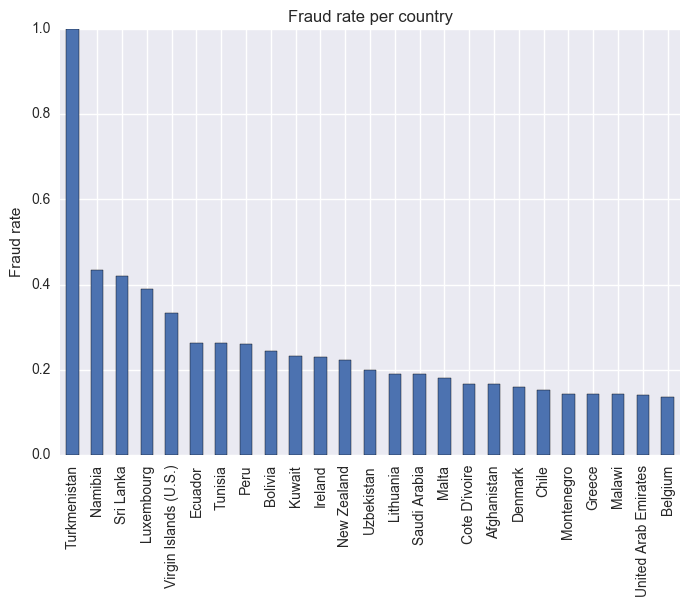

In [20]:
df_fraud_countries = data[data['class'] == 1].groupby('country')['country'].count()
df_allcountries = data.groupby('country')['country'].count()
frauds = pd.concat([df_fraud_countries, df_allcountries], axis=1)
frauds.columns = ['fraud nr','total nr']
frauds = frauds.fillna(0)
frauds['fraud_rate'] = frauds['fraud nr']/frauds['total nr']
frauds.fraud_rate.sort_values(ascending=False).head(25).plot(kind='bar')
plt.ylabel('Fraud rate')
plt.title('Fraud rate per country')

In [40]:
fraud_data['class'].value_counts(normalize = True)

0    0.906354
1    0.093646
Name: class, dtype: float64

#### The % of fraudulent transactions is 9.3%, This clearly indicates that the target classes are imbalanced as expected from a fraud detection dataset

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000028E3BE363C8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000028E47C09128>]], dtype=object)

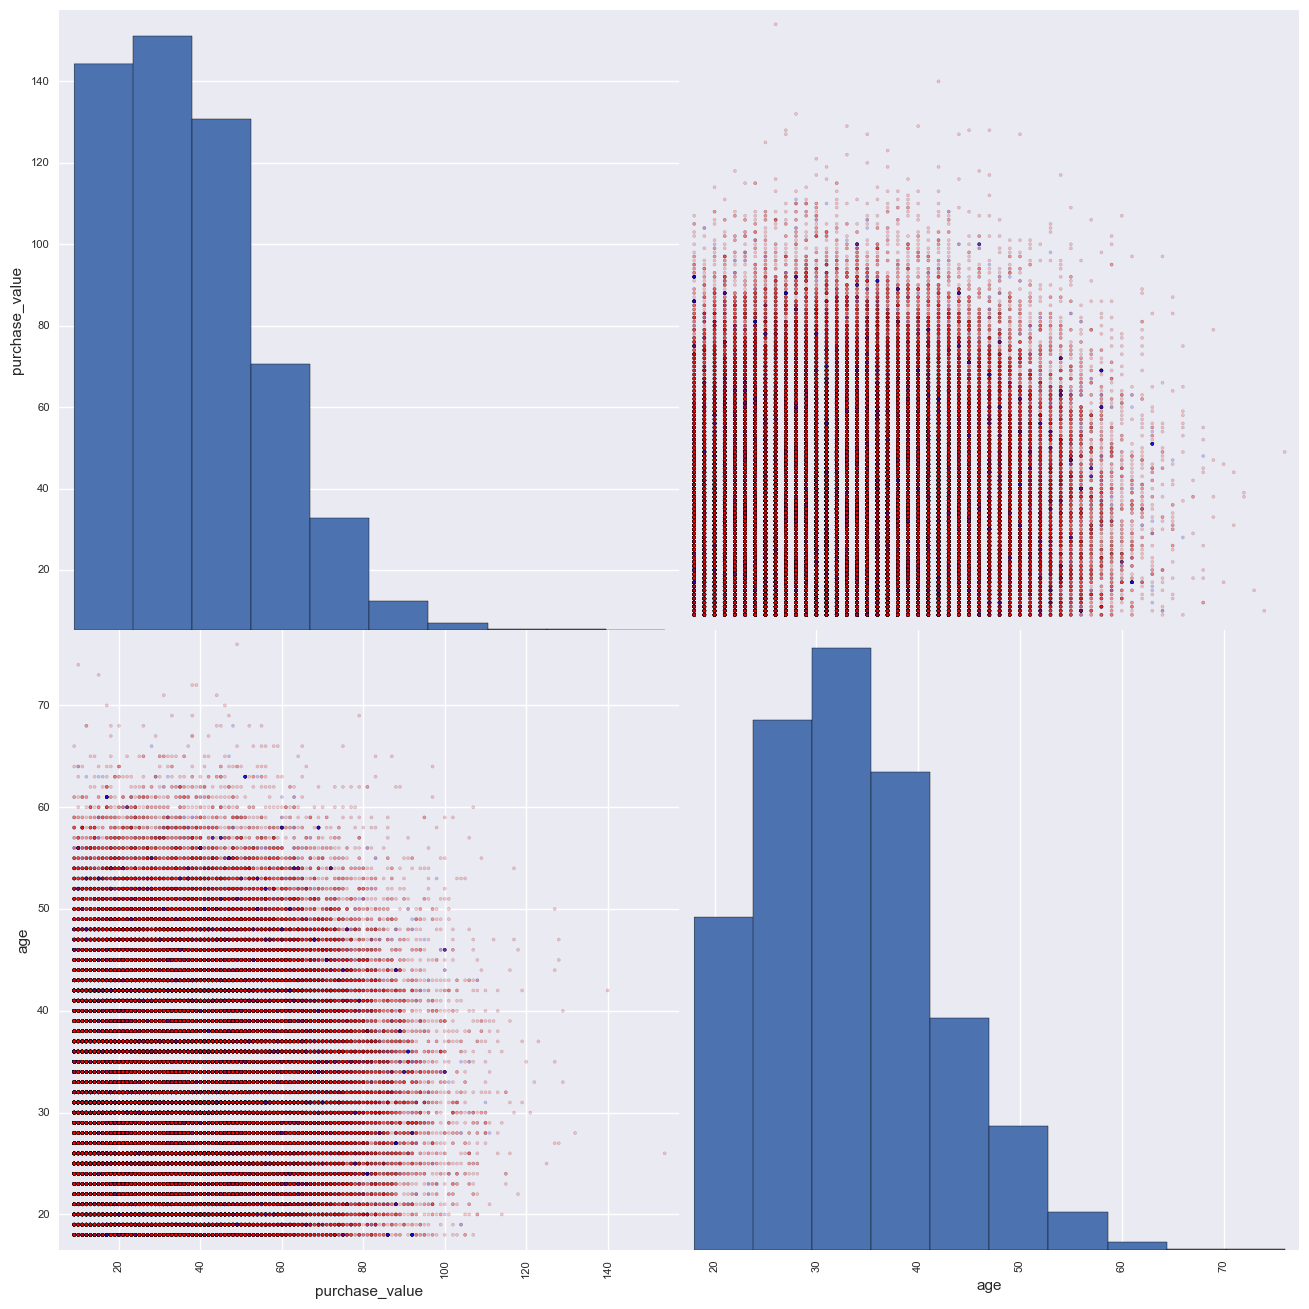

In [25]:
data['conversion_time'] = data.purchase_time - data.signup_time
features = ['purchase_value', 'age']
colors = ['blue' if ix else 'red' for ix in data['class']]
scatter_matrix(data[features], alpha=0.2, figsize=(16, 16), diagonal='hist', c=colors)

In [56]:
# First reload the dataset
fraud_df = data

# Add column corresponding to the number of unique user id's associated with the given device id
userid_count = fraud_df.groupby("device_id").user_id.count()
fraud_df["userids_per_deviceid"] = fraud_df.device_id.apply(lambda x: userid_count[x])

# Add column corresponding to the number of unique user id's associated with the given ip address
userid_count = fraud_df.groupby("ip_address").user_id.count()
fraud_df["userids_per_ipaddress"] = fraud_df.ip_address.apply(lambda x: userid_count[x])

# Add column for the average of the previous two columns
fraud_df["mean_number_of_userids"] = (fraud_df.userids_per_deviceid + fraud_df.userids_per_ipaddress) * 0.5

# Convert sign-up time and purchase time to datetime objects
fraud_df.signup_time = fraud_df.signup_time.apply(pd.to_datetime)
fraud_df.purchase_time = fraud_df.purchase_time.apply(pd.to_datetime)

# Add columns for the number of seconds and days between purchase and sign-up times
fraud_df["signup_to_purchase_seconds"] = (fraud_df.purchase_time - fraud_df.signup_time).apply(lambda x: x.seconds)

# Create dummy columns for country feature
country_dummies = pd.get_dummies(fraud_df.country, prefix='country')
fraud_df = pd.concat([fraud_df, country_dummies], axis=1)

# Drop spurious columns
fraud_df.drop(["user_id", 
               "signup_time", 
               "purchase_time", 
               "device_id", 
               "ip_address", 
               "userids_per_deviceid",
               "userids_per_ipaddress",
               "country"
               ], axis=1, inplace=True)

In [57]:
fraud_df.head()

,purchase_value,source,browser,sex,age,class,mean_number_of_userids,signup_to_purchase_seconds,conversion_time,country_Afghanistan,...,country_Uruguay,country_Uzbekistan,country_Vanuatu,country_Venezuela,country_Viet Nam,country_Virgin Islands (U.S.),country_Yemen,country_Zambia,country_Zimbabwe,country_unknown
0,34,SEO,Chrome,0,39,0,1.0,13882,52 days 03:51:22,0,...,0,0,0,0,0,0,0,0,0,0
1,16,Ads,Chrome,1,53,0,1.0,17944,0 days 04:59:04,0,...,0,0,0,0,0,0,0,0,0,0
2,15,SEO,Opera,0,53,1,12.0,1,0 days 00:00:01,0,...,0,0,0,0,0,0,0,0,0,0
3,44,SEO,Safari,0,41,0,1.0,60085,5 days 16:41:25,0,...,0,0,0,0,0,0,0,0,0,1
4,39,Ads,Safari,0,45,0,1.0,41461,50 days 11:31:01,0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
def append_dummies(df,col):
    dummies = pd.get_dummies(df[col],prefix = col)
    df = pd.concat([df,dummies],axis=1)
    df.pop(col)
    return df
def new_features(df):
    df = append_dummies(df, 'source')
    df = append_dummies(df, 'browser')
    return df
fraud_df = new_features(fraud_df)


In [59]:

def oversample(X, y, target = .45):
    """
    INPUT:
    X, y - data
    target - the percentage of ones class
             observations in the output
    OUTPUT:
    X_new, y_new - oversampled data
    oversample randomly replicates ones observations
    in X, y to achieve the target proportion
    """
    proportion = np.mean(y)
    if proportion > target:
        return X, y
    # determine how many new ones observations to generate
    ones_count = sum(y)
    zeros_count = len(y) - ones_count
    target_ones_count = int(round(target*zeros_count / (1. - target)))
    number_of_new_observations = target_ones_count - ones_count
    # randomly generate new ones observations
    ones_obs_indices = np.where(y==1)[0] # np.where returns a tuple containing an array of indices
    new_obs_indices = np.random.choice(ones_obs_indices, size=number_of_new_observations, replace=True)
    X_new, y_new = X[new_obs_indices], y[new_obs_indices]
    X_ones = np.vstack((X[ones_obs_indices], X_new))
    y_ones = np.concatenate((y[ones_obs_indices], y_new))
    X_zeros = X[y==0]
    y_zeros = y[y==0]
    X_final = np.vstack((X_zeros, X_ones))
    y_final = np.concatenate((y_zeros, y_ones))
    return X_final, y_final

In [67]:
fraud_df.conversion_time = fraud_df.conversion_time.dt.seconds + 60*60*24*fraud_df.conversion_time.dt.days

In [68]:
y = fraud_df.pop('class').values
feature = fraud_df.columns.tolist()[:]
X = fraud_df[feature].values
X_final, y_final = oversample(X, y)

In [70]:
fraud_rate = sum(y_final) / len(X_final)
fraud_rate

0.45000000000000001

### Now we can say that the class is balanced and model can give predictions without Bias. There are other similar methods for handaling the imbalanced class like Undersampling, SMOTE, performing under and over sampling both on respective classes

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.20, random_state=67)

#### Lets try Gradient Boost classifier as tree based methods seem to perform well on the imbalanced or fradulent data, also being easy to scale for larger datasets

In [74]:
gbc = GradientBoostingClassifier(n_estimators=50, max_depth=8, subsample=0.5, 
                                 max_features='auto', learning_rate=0.1)
gbc.fit(X_train, y_train)
gbc.score(X_test,y_test)

0.84320536503092125

In [77]:
pd.crosstab(y_test, gbc.predict(X_test))

col_0,0,1
row_0,,
0,25840,1599
1,6210,16155


In [75]:
def plot_confusion_matrix(model, X_test, y_true):
    cm = confusion_matrix(y_true, model.predict(X_test))

    print(cm)

    # Show confusion matrix in a separate window
    plt.matshow(cm)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

[[25840  1599]
 [ 6210 16155]]


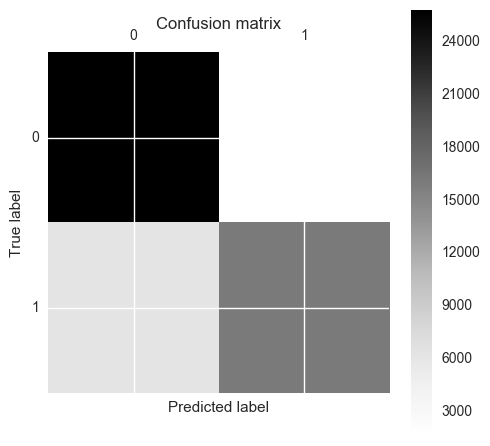

In [76]:
plot_confusion_matrix(gbc, X_test, y_test)

In [78]:
skm.roc_auc_score(y_test, gbc.predict(X_test))

0.83202964277886415

In [80]:
rfc = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rfc.fit(X_train, y_train)
rfc.score(X_test, y_test)

0.99546221187053252

In [87]:
conf_mat = pd.crosstab(y_test, rfc.predict(X_test))
conf_mat

col_0,0,1
row_0,,
0,27234,205
1,21,22344


In [82]:
skm.roc_auc_score(y_test, rfc.predict(X_test))

0.99579495755587244

In [99]:
precision = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])
recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])

In [110]:
F1 = 2*((precision*recall)/(precision+recall))
("F1 score is: " , F1)

('F1 score is: ', 0.99586791969868715)

[[27234   205]
 [   21 22344]]


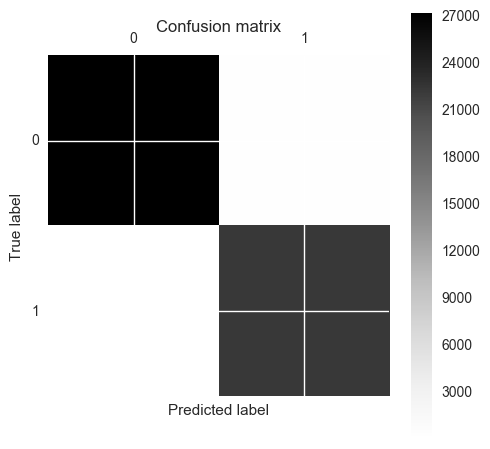

In [83]:

plot_confusion_matrix(rfc, X_test, y_test)

In [84]:

def plot_importance(clf, feature, max_features=10):
    '''Plot feature importance'''
    feature_importance = clf.feature_importances_
    # make importances relative to max importance
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    
    # Show only top features
    pos = pos[-max_features:]
    feature_importance = (feature_importance[sorted_idx])[-max_features:]
    feature = np.array(feature)
    feature_names = (feature[sorted_idx])[-max_features:]
    
    plt.barh(pos, feature_importance, align='center')
    plt.yticks(pos, feature_names)
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')

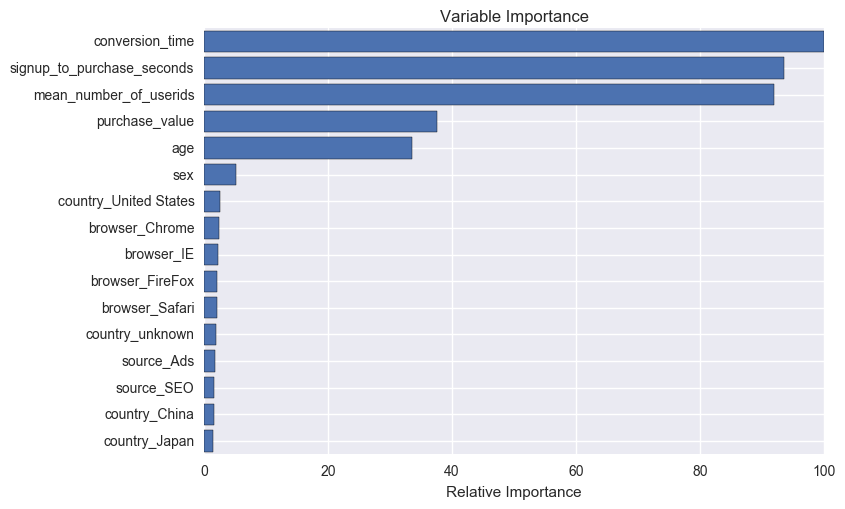

In [85]:
plot_importance(rfc, feature, max_features=16)

#### The above mentioned graph mentiones some of the features which are a strong indicators of somone who is likely to commit a fradulent activity on thier ecommerce purchase

### 2) We can use the evaluation matrix like F1 score of 0.99 which is a combination of precision and recall using harmonic mean, It acts as a good measure of the model performance for any detection/classification model specially with imbalanced class

### 3) We can use the above mentioned Random Forest model for online detection in real time by setting up cetrain data pipeline to replicate the features which are used in the models as well as scale in accordance to the training set, We need to set up certain rules that can indicate clearly weather the user who is fraud aligns with certain rules like if the system cant tell us with certain confidence and the amount of transaction is low then we can let that transaction go without a flag. This system is only good for certain time interval as the fraudsters have a history of improvising upon thier ways of commiting frauds and we need to retrain the model using new data after certain intervals of time